In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import os
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

100%|██████████| 170M/170M [00:06<00:00, 28.4MB/s]


In [ ]:
class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.shortcut = nn.Sequential()
    if stride !=1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels)
      )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    return F.relu(out)

In [ ]:
class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_channels = 64

    self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)

    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

    self.linear = nn.Linear(512, num_classes)

  def _make_layer(self, block, out_channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)

    layers = []

    for s in strides:
      layers.append(block(self.in_channels, out_channels, s))
      self.in_channels = out_channels

    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
device = torch.device('cuda')
model = ResNet18().to(device)
lossfn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 20
train_accs = []
train_losses = []

for epoch in range(epochs):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for data in trainloader:
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = lossfn(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

  print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Accuracy={epoch_acc:.2f}%")

Epoch 1: Loss=1.3726, Accuracy=50.15%
Epoch 2: Loss=0.8392, Accuracy=70.09%
Epoch 3: Loss=0.6078, Accuracy=78.59%
Epoch 4: Loss=0.4668, Accuracy=83.63%
Epoch 5: Loss=0.3700, Accuracy=87.07%
Epoch 6: Loss=0.2869, Accuracy=89.91%
Epoch 7: Loss=0.2087, Accuracy=92.57%
Epoch 8: Loss=0.1518, Accuracy=94.57%
Epoch 9: Loss=0.1089, Accuracy=96.14%
Epoch 10: Loss=0.0878, Accuracy=96.86%
Epoch 11: Loss=0.0751, Accuracy=97.32%
Epoch 12: Loss=0.0593, Accuracy=97.87%
Epoch 13: Loss=0.0613, Accuracy=97.86%
Epoch 14: Loss=0.0505, Accuracy=98.21%
Epoch 15: Loss=0.0419, Accuracy=98.52%
Epoch 16: Loss=0.0438, Accuracy=98.46%
Epoch 17: Loss=0.0361, Accuracy=98.71%
Epoch 18: Loss=0.0363, Accuracy=98.73%
Epoch 19: Loss=0.0314, Accuracy=98.89%
Epoch 20: Loss=0.0358, Accuracy=98.73%


In [ ]:
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), "checkpoints/resnet18_cifar10.pth")

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 83.01%


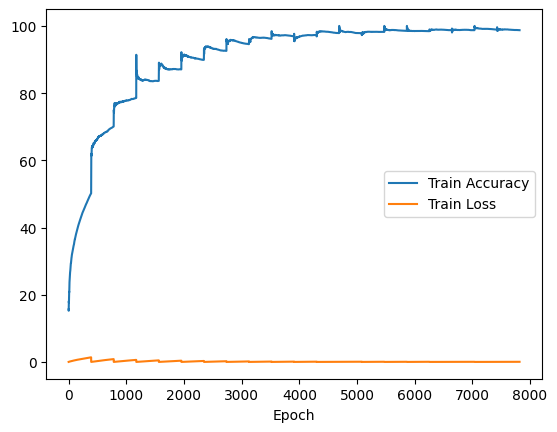

In [ ]:
plt.plot(train_accs, label='Train Accuracy')
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()